In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import chardet
from mpl_toolkits.mplot3d.axes3d import Axes3D
import seaborn as sns
import pylab
from scipy.optimize import curve_fit

In [2]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

In [3]:
with open('measurements/lateraldata.txt', 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv('measurements/lateraldata.txt', encoding=result['encoding'], sep=';', comment='#')
zdata=pd.read_csv('measurements/mess2.txt', encoding=result['encoding'], sep=';', comment='#')

In [4]:
df0=df[(df['z[mm]']==0.0)]
df3=df[(df['z[mm]']==3.2)]
g0=df0[['x[mm]','y[mm]','Value']].pivot(index='x[mm]', columns='y[mm]', values='Value')
g3=df3[['x[mm]','y[mm]','Value']].pivot(index='x[mm]', columns='y[mm]', values='Value')

In [5]:
data=np.loadtxt('simulations/praktikum001_fort.22.lis',skiprows=9)
data1=np.loadtxt('simulations/praktikum001_fort.21.lis',skiprows=9)

In [6]:
def pool_forward(A_prev, f=3,stride=1, mode = "average"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    ( n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros(( n_H, n_W, n_C))              
    a_prev_slice = A_prev
    for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
        vert_start = stride * h 
        vert_end = vert_start + f
        for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
            horiz_start = stride * w
            horiz_end = horiz_start + f
                
            for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                a_slice_prev = a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                if mode == "max":
                    A[ h, w, c] = np.max(a_slice_prev)
                elif mode == "average":
                    A[ h, w, c] = np.mean(a_slice_prev)
                elif mode=="sum":
                    A[h,w,c]=np.sum(a_slice_prev)    
    # YOUR CODE ENDS HERE
    
    # Store the input and hparameters in "cache" for pool_backward()
    
    # Making sure your output shape is correct
    assert(A.shape == (n_H, n_W, n_C))
    
    return A

In [7]:
ll=pool_forward(data.reshape((110,110,1000))[27:83,27:83,200:], f=10, mode = "average")
l=pool_forward(data.reshape((110,110,1000))[:,:,200:], f=10, mode = "average")
h=pool_forward(data.reshape((110,110,1000))[:,:,200:], f=110, mode = "average")

In [8]:
def fmax(data):
    zmax=0
    row=0
    coll=0
    for row in data.index:
        if data.loc[row].max()>zmax:
            zmax=data.loc[row].max()
            roww=row
    zmax=0
    for col in data.columns:
        if data.loc[:,col].max()>zmax:
            zmax=data.loc[:,col].max()
            coll=col
    return roww,coll

In [9]:
df_cm = pd.DataFrame(ll[:,:,16]*40000000*1.60218e-7, index = np.linspace(20.225,25.225,47),
                  columns = np.linspace(24.20,29.20,47))
df_cm.columns=df_cm.columns.map(lambda x: round(x, 2))
df_cm.index=df_cm.index.map(lambda x: round(x, 2))

df_cm3 = pd.DataFrame(ll[:,:,16+128]*40000000*1.60218e-7, index = np.linspace(20.225,25.225,47),
                  columns = np.linspace(24.20,29.20,47))
df_cm3.columns=df_cm.columns.map(lambda x: round(x, 2))
df_cm3.index=df_cm.index.map(lambda x: round(x, 2))

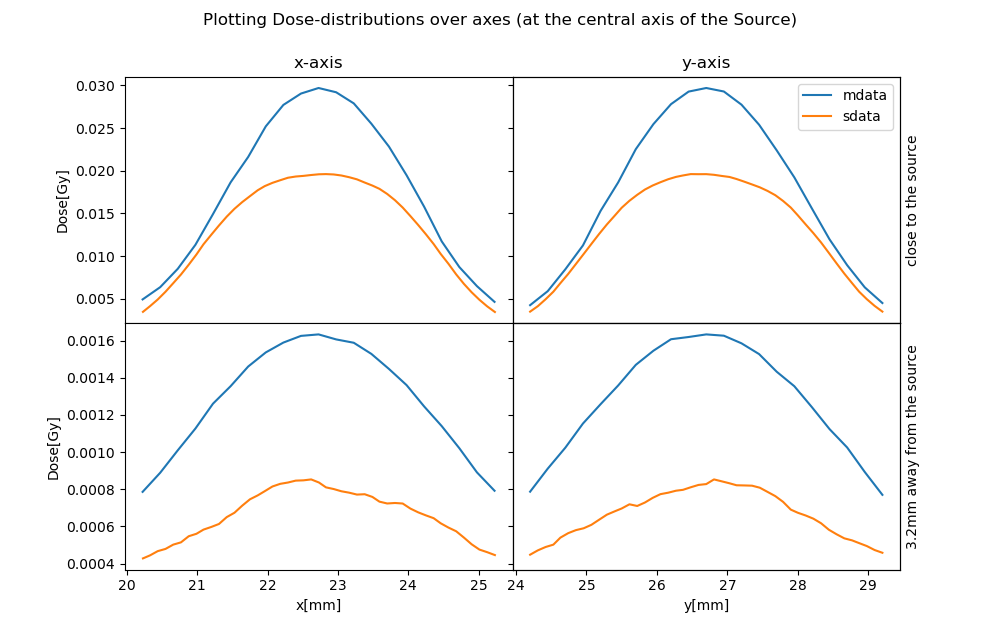

In [10]:
fig = plt.figure(figsize=(10,6.4))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Plotting Dose-distributions over axes (at the central axis of the Source)')

sns.lineplot(data=g0.loc[fmax(g0)[0]], ax=ax2,label='mdata')
sns.lineplot(data=g0.loc[:,fmax(g0)[1]],ax=ax1)

sns.lineplot(data=g3.loc[fmax(g3)[0]], ax=ax4)
sns.lineplot(data=g3.loc[:,fmax(g3)[1]],ax=ax3)

sns.lineplot(data=df_cm.loc[fmax(df_cm)[0]], ax=ax2,label='sdata')
sns.lineplot(data=df_cm.loc[:,fmax(df_cm)[1]],ax=ax1)
sns.lineplot(data=df_cm3.loc[fmax(df_cm3)[0]], ax=ax4)
sns.lineplot(data=df_cm3.loc[:,fmax(df_cm3)[1]],ax=ax3)


ax1.set(ylabel='Dose[Gy]')
ax3.set(xlabel='x[mm]',ylabel='Dose[Gy]')
ax4.set(xlabel='y[mm]')
for ax in fig.get_axes():
    ax.label_outer()
axes2 = ax2.twinx()
axes2.set_yticks([])
axes2.set_ylabel('close to the source')
axes3 = ax4.twinx()
axes3.set_yticks([])
axes3.set_ylabel('3.2mm away from the source')
ax1.set_title('x-axis')
ax2.set_title('y-axis')
ax2.legend()
plt.show()

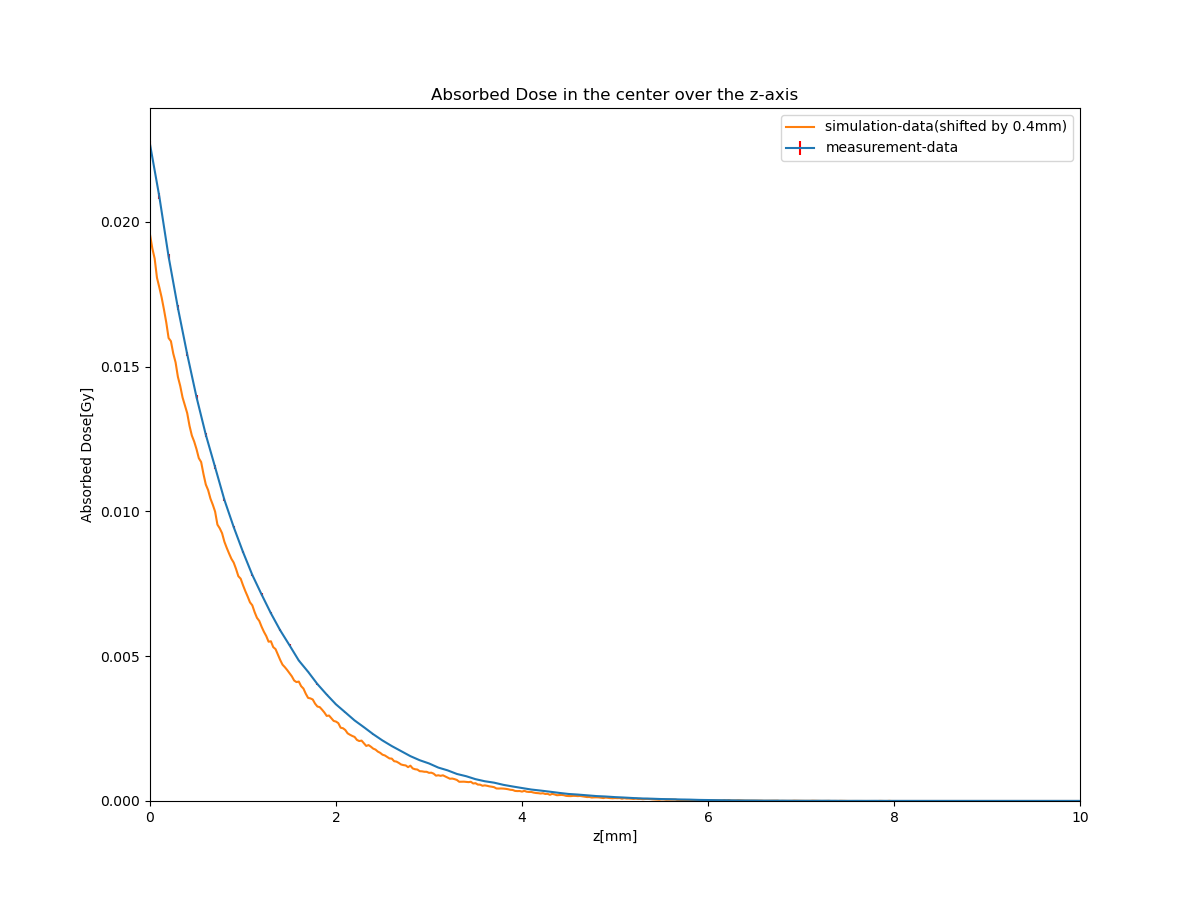

In [11]:
fig, ax = plt.subplots(figsize=(12,9))
xx=np.linspace(0,2-0.0025,800)
err=np.array([(lambda x: ((0.5+0.25*x['Resolution'])/100)*x['Value'])(zdata)]).flatten()

plt.errorbar(zdata['z[mm]'], zdata['Value'], yerr=err, fmt='-',ecolor='red',label='measurement-data')
plt.plot(xx[0:400]*10, ll[23,23,16:416]*40000000*1.60218e-7,label='simulation-data(shifted by 0.4mm)')

plt.xlabel('z[mm]')
plt.ylabel('Absorbed Dose[Gy]')
plt.title('Absorbed Dose in the center over the z-axis')
plt.xlim(0,10)
plt.ylim(0,None)
plt.legend()
plt.show()

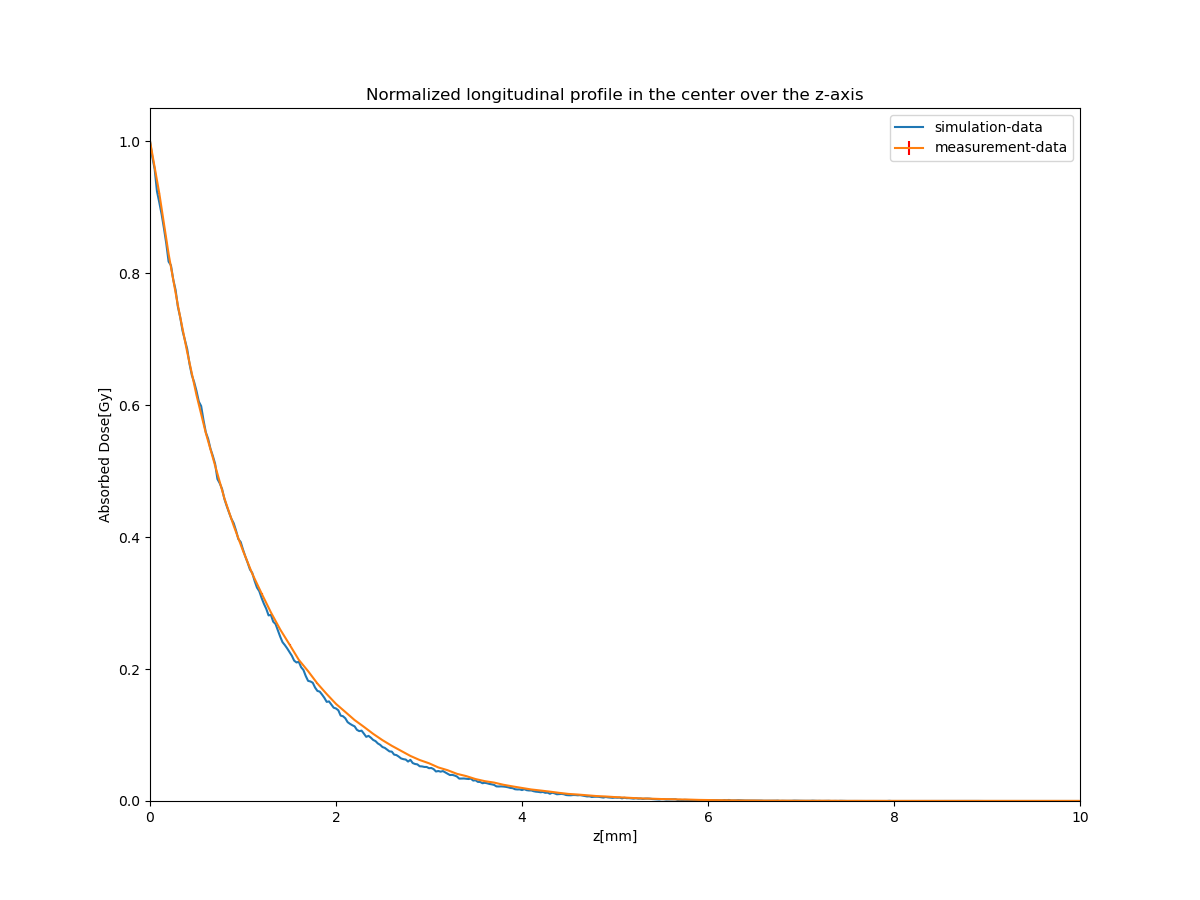

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
xx=np.linspace(0,2-0.0025,800)
err=np.array([(lambda x: ((0.5+0.25*x['Resolution'])/100)*x['Value'])(zdata)]).flatten()

plt.plot(xx[0:400]*10,ll[23,23,16:416]/np.max(ll[23,23,16:416]),label='simulation-data')
plt.errorbar(zdata['z[mm]'], zdata['Value']/np.max(zdata['Value']), yerr=err, fmt='-',ecolor='red',label='measurement-data')

plt.xlabel('z[mm]')
plt.ylabel('Absorbed Dose[Gy]')
plt.title('Normalized longitudinal profile in the center over the z-axis')
plt.xlim(0,10)
plt.ylim(0,None)
plt.legend()
plt.show()

In [13]:
def r(x,a,b):
    return a/((x+b)**2)
def test(x,a):
    return a*np.exp(-x)

1/r²: best [a  b]= [0.03747339 1.22227607] and its std [4.34569240e-06 1.77959046e-03]
exp: best [a] [0.0231045]  and its std [1.91495379e-09]


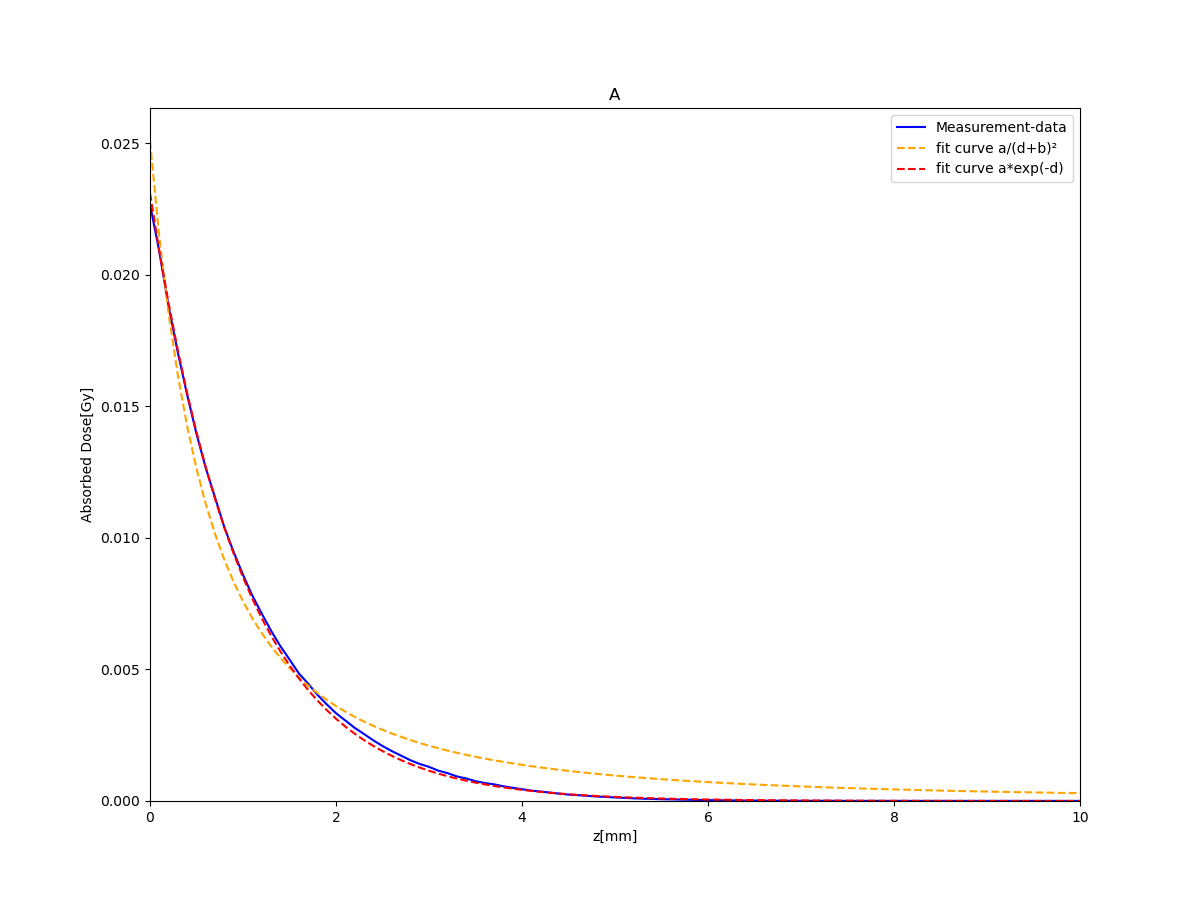

1/r²: R²= 0.9769289757544706
exp: R²= 0.9995496866672677


In [75]:
fig, ax = plt.subplots(figsize=(12,9))
popt1, pcov1 = curve_fit(r,zdata['z[mm]'], zdata['Value'])
popt, pcov = curve_fit(test,zdata['z[mm]'], zdata['Value'])
print('1/r²: best [a  b]=',popt1,'and its std', np.diagonal(pcov1))
print('exp: best [a]',popt,' and its std', np.diagonal(pcov))
plt.plot(zdata['z[mm]'], zdata['Value'],label='Measurement-data',color='blue')
plt.plot(zdata['z[mm]'], r(zdata['z[mm]'],*popt1),label='fit curve a/(d+b)²',color='orange',ls='--')
plt.plot(zdata['z[mm]'], test(zdata['z[mm]'],*popt),label='fit curve a*exp(-d)',color='red',ls='--')

plt.xlim(0,10)
plt.ylim(0,None)
plt.xlabel('z[mm]')
plt.ylabel('Absorbed Dose[Gy]')
plt.title('A')
plt.legend()
plt.show()
residuals = zdata['Value']- r(zdata['z[mm]'], *popt1)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((zdata['Value']-np.mean(zdata['Value']))**2)
r_squared = 1 - (ss_res / ss_tot)
print('1/r²: R²=',r_squared)
residuals = zdata['Value']- test(zdata['z[mm]'], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((zdata['Value']-np.mean(zdata['Value']))**2)
r_squared = 1 - (ss_res / ss_tot)
print('exp: R²=',r_squared)

1/r²: best [a  b]= [0.04605732 1.20205412] and its std [1.99045000e-06 5.52752676e-04]
exp: best [a] [0.02892386]  and its std [1.36234044e-09]


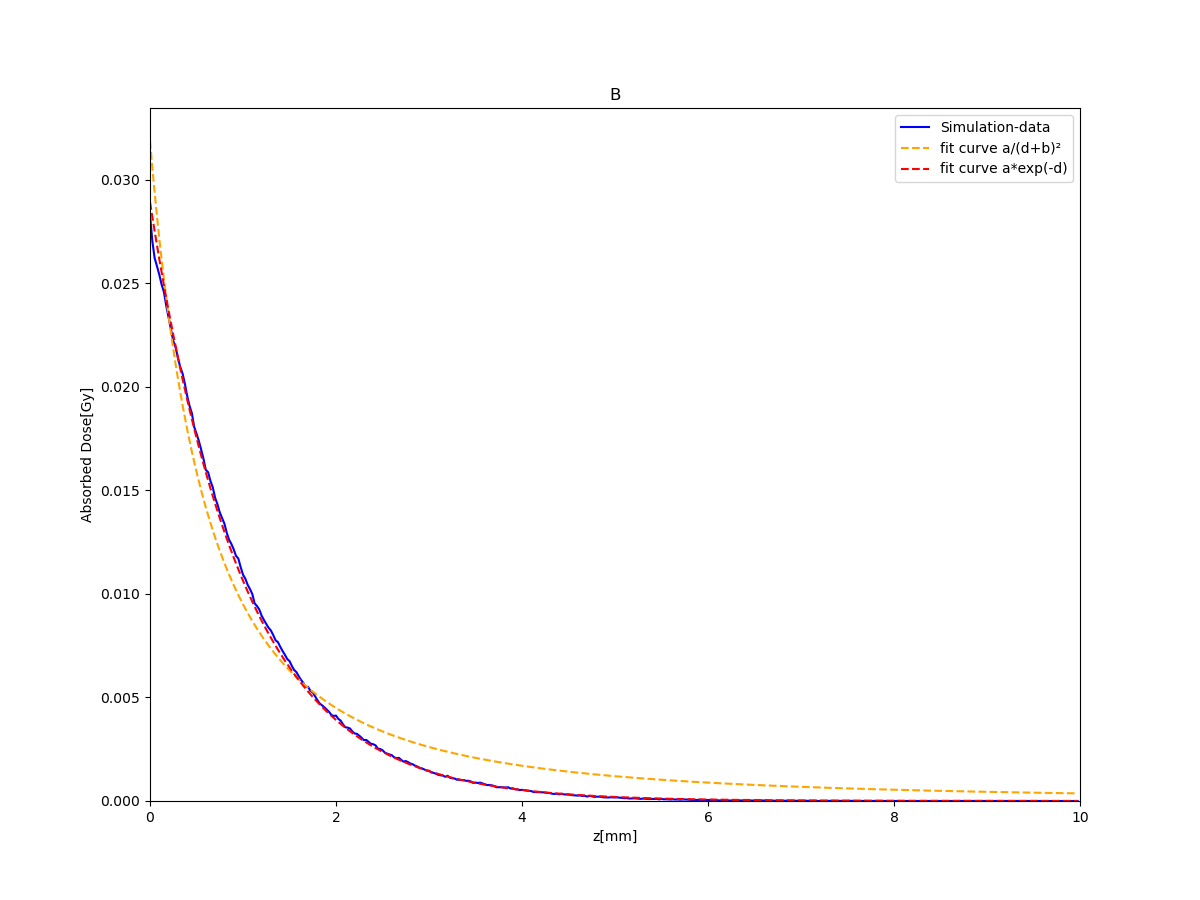

1/r²: R²= 0.9718082001314924
exp: R²= 0.9991854578764547


In [76]:
fig, ax = plt.subplots(figsize=(12,9))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

popt1, pcov1 = curve_fit(r, xx[0:400]*10, ll[23,23,0:400]*40000000*1.60218e-7)
popt, pcov = curve_fit(test,xx[0:400]*10, ll[23,23,0:400]*40000000*1.60218e-7)
print('1/r²: best [a  b]=',popt1,'and its std', np.diagonal(pcov1))
print('exp: best [a]',popt,' and its std', np.diagonal(pcov))
x=xx[0:400]*10
y=ll[23,23,0:400]*40000000*1.60218e-7
plt.plot(xx[:400]*10, ll[23,23,0:400]*40000000*1.60218e-7,label='Simulation-data',color='blue')
plt.plot(xx[:400]*10, r(xx[:400]*10, *popt1),label='fit curve a/(d+b)²',color='orange',ls='--')
plt.plot(xx[:400]*10, test(xx[:400]*10, *popt),label='fit curve a*exp(-d)',color='red',ls='--')


plt.xlabel('z[mm]')
plt.ylabel('Absorbed Dose[Gy]')
plt.title('B')
plt.xlim(0,10)
plt.ylim(0,None)
plt.legend()
plt.show()
residuals = y- r(x, *popt1)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print('1/r²: R²=',r_squared)
residuals = y- test(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print('exp: R²=',r_squared)


In [89]:
def normal(x,x0,sigma,c):
    return c+np.exp(-((x-x0)/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))

In [81]:
def getr2(func,x,y,best):
    residuals = y- func(x, *best)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

(close,m):best [x0 sigma c] [26.71219834  3.4580671  -0.08758178]  and its std [1.05083436e-03 3.28073834e-03 2.21504221e-06]
(close,m) R²= 0.9632129206177069
(close,s):best [x0 sigma c] [26.70007454  4.02071046 -0.07951619]  and its std [6.27826025e-05 2.72495969e-04 1.14917159e-07]
(close,s) R²= 0.9940702865233123
(away,m):best [x0 sigma c] [22.72684013 11.23072742 -0.03392134]  and its std [2.78583240e-04 8.62880430e-03 8.17949052e-08]
(away,m) R²= 0.9891999349890097
(away,s):best [x0 sigma c] [22.78270717 14.42784435 -0.02684277]  and its std [4.33458679e-04 2.29680191e-02 8.17770572e-08]
(away,s) R²= 0.9587692090380908


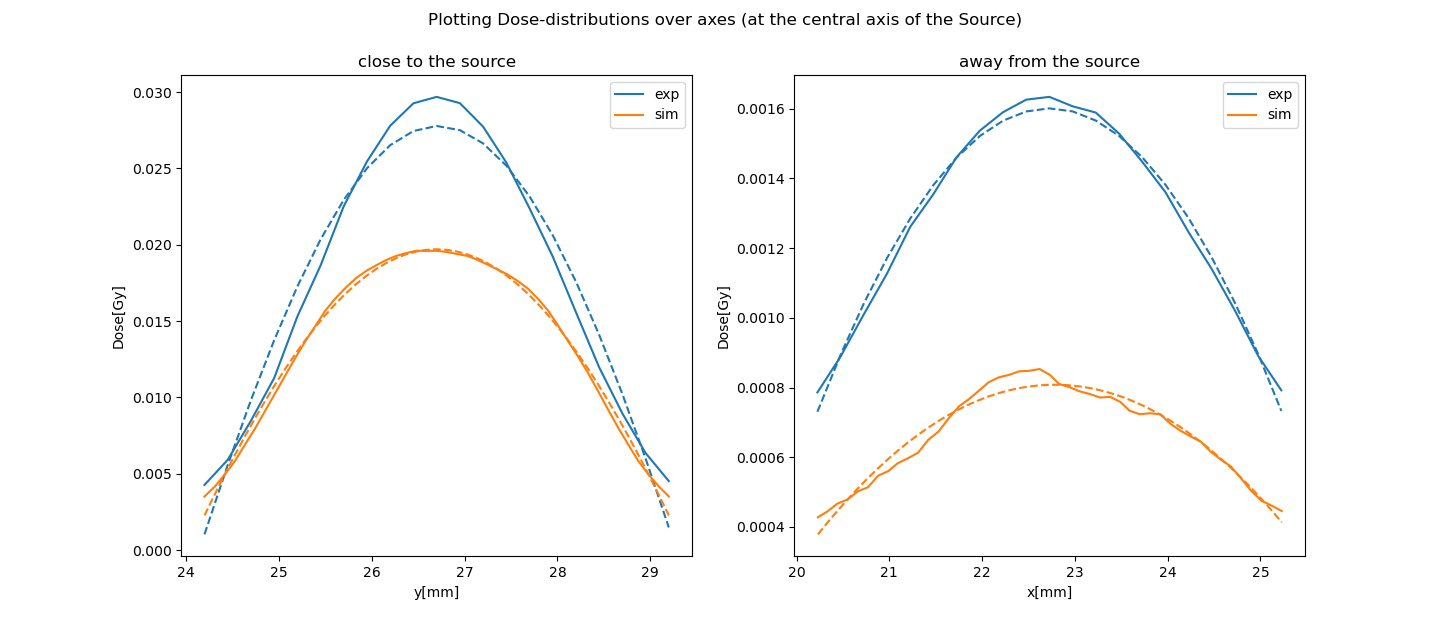

In [91]:
fig, axs = plt.subplots(1,2,figsize=(14.5,6.25))
fig.suptitle('Plotting Dose-distributions over axes (at the central axis of the Source)')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

sns.lineplot(data=g0.loc[fmax(g0)[0]], ax=axs[0],label='exp',color=colors[0])
popt,pcov=curve_fit(normal,g0.loc[fmax(g0)[0]].index, g0.loc[fmax(g0)[0]].values,p0=[fmax(g0)[1],3,0])
print('(close,m):best [x0 sigma c]',popt,' and its std', np.diagonal(pcov))
axs[0].plot(g0.loc[fmax(g0)[0]].index,normal(g0.loc[fmax(g0)[0]].index,*popt),color=colors[0],ls='--')
print('(close,m) R²=',getr2(normal,g0.loc[fmax(g0)[0]].index, g0.loc[fmax(g0)[0]].values,popt))

sns.lineplot(data=df_cm.loc[fmax(df_cm)[0]], ax=axs[0],label='sim',color=colors[1])
popt1,pcov1=curve_fit(normal,df_cm.loc[fmax(df_cm)[0]].index, df_cm.loc[fmax(df_cm)[0]].values,p0=[fmax(df_cm)[1],4,0])
print('(close,s):best [x0 sigma c]',popt1,' and its std', np.diagonal(pcov1))
axs[0].plot(df_cm.loc[fmax(df_cm)[0]].index,normal(df_cm.loc[fmax(df_cm)[0]].index,*popt1),color=colors[1],ls='--')
print('(close,s) R²=',getr2(normal,df_cm.loc[fmax(df_cm)[0]].index, df_cm.loc[fmax(df_cm)[0]].values,popt1))


sns.lineplot(data=g3.loc[:,fmax(g3)[1]], ax=axs[1],color=colors[0],label='exp')
popt3,pcov3=curve_fit(normal,g3.loc[:,fmax(g3)[1]].index, g3.loc[:,fmax(g3)[1]].values,p0=[fmax(g0)[0],11,0])
print('(away,m):best [x0 sigma c]',popt3,' and its std', np.diagonal(pcov3))
axs[1].plot(g3.loc[:,fmax(g3)[1]].index,normal(g0.loc[:,fmax(g3)[1]].index,*popt3),color=colors[0],ls='--')
print('(away,m) R²=',getr2(normal,g3.loc[:,fmax(g3)[1]].index, g3.loc[:,fmax(g3)[1]].values,popt3))

sns.lineplot(data=df_cm3.loc[:,fmax(df_cm3)[1]], ax=axs[1],label='sim',color=colors[1])
popt31,pcov31=curve_fit(normal,df_cm3.loc[:,fmax(df_cm3)[1]].index, df_cm3.loc[:,fmax(df_cm3)[1]].values,p0=[fmax(df_cm3)[0],14,0])
print('(away,s):best [x0 sigma c]',popt31,' and its std', np.diagonal(pcov31))
axs[1].plot(df_cm3.loc[:,fmax(df_cm3)[1]].index,normal(df_cm3.loc[:,fmax(df_cm3)[1]].index,*popt31),color=colors[1],ls='--')
print('(away,s) R²=',getr2(normal,df_cm3.loc[:,fmax(df_cm3)[1]].index, df_cm3.loc[:,fmax(df_cm3)[1]].values,popt31))


axs[0].set_title('close to the source')
axs[1].set_title('away from the source')
axs[0].set(ylabel='Dose[Gy]')
axs[1].set(ylabel='Dose[Gy]')
"""
ax1.set(ylabel='Dose[Gy]')
ax3.set(xlabel='x[mm]',ylabel='Dose[Gy]')
ax4.set(xlabel='y[mm]')
for ax in fig.get_axes():
    ax.label_outer()
axes2 = ax2.twinx()
axes2.set_yticks([])
axes2.set_ylabel('close to the source')
axes3 = ax4.twinx()
axes3.set_yticks([])
axes3.set_ylabel('3.2mm away from the source')

ax2.set_title('y-axis')
ax2.legend()
"""
plt.show()